# Programming assignment 5: spotting cars using convolutional neural networks

Participants: Arvid Nyberg & Alfred Karlsson

In [71]:
# Imports

from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Flatten, Conv2D, MaxPooling2D
from tensorflow.keras.optimizers import SGD
from tensorflow.keras import applications
from tensorflow.keras.preprocessing.image import load_img, img_to_array
from tensorflow.keras.applications.vgg16 import decode_predictions, preprocess_input
from matplotlib import pyplot as plt
from pathlib import Path
import numpy as np
import os

## Loading images from a directory

Found 1600 images belonging to 2 classes.
Found 1600 images belonging to 2 classes.
Found 576 images belonging to 2 classes.
(32, 64, 64, 3)
(32,)
1.0


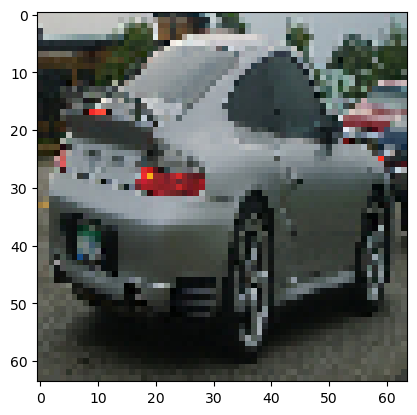

In [72]:
# ImageDataGenerator determines how images are converted to NumPy data
data_gen = ImageDataGenerator(rescale=1.0/255)
data_gen_aug = ImageDataGenerator(
        rescale=1.0/255,
        horizontal_flip = True,
        vertical_flip = True
)

img_size = 64 # Resize to 64x64 pixels
batch_size = 32

train_generator = data_gen_aug.flow_from_directory(
        './train',
        target_size=(img_size, img_size), # Resize to 64x64 pixels
        batch_size=batch_size,
        class_mode='binary',
        classes=['other', 'car'], # 0 = other 1 = car
        seed=12345,
        shuffle=True
)

Xbatch_aug, Ybatch_aug = train_generator.next()

train_generator = data_gen.flow_from_directory(
        './train',
        target_size=(img_size, img_size),
        batch_size=batch_size,
        class_mode='binary',
        classes=['other', 'car'],
        seed=12345,
        shuffle=True)

Xbatch, Ybatch = train_generator.next()

validation_generator = data_gen.flow_from_directory(
        './validation',
        target_size=(img_size, img_size),
        batch_size=batch_size,
        class_mode='binary',
        classes=['other', 'car'],
        seed=12345,
        shuffle=True)

x_test, y_test = validation_generator.next()

print(Xbatch.shape)
print(Ybatch.shape)
print(Ybatch[0])
plt.imshow(Xbatch[0])

## Part 1 & 2: Training a convolutional neural network (including data augmentation)

In [73]:
# Builds a CNN
def make_convnet():
    model = Sequential()
    model.add(Conv2D(8,(3,3), activation="relu",input_shape=(img_size, img_size, 3)))
    model.add(MaxPooling2D(pool_size=(2,2)))
    model.add(Conv2D(16,(3,3), activation="relu"))
    model.add(MaxPooling2D(pool_size=(2,2)))
    model.add(Conv2D(32,(3,3), activation="relu"))
    model.add(MaxPooling2D(pool_size=(2,2)))
    model.add(Conv2D(64,(3,3), activation="relu"))
    model.add(MaxPooling2D(pool_size=(2,2)))
    model.add(Flatten())
    model.add(Dense(512, activation='relu'))
    model.add(Dense(1, activation='sigmoid'))

    model.compile(loss='binary_crossentropy',
              optimizer=(SGD(learning_rate=0.01,momentum=0.1, nesterov=True)),
              metrics=['accuracy'])
    return model

model = make_convnet()
model_aug = make_convnet()

# model.summary()
epochs = 50
history = model.fit(Xbatch, Ybatch,
          batch_size=batch_size,
          epochs=epochs,
          verbose=0,
          validation_data=(x_test, y_test))
score = model.evaluate(x_test, y_test, verbose=0)
print('Test loss:', score[0])
print('Test accuracy:', score[1])
history_aug = model_aug.fit(Xbatch_aug, Ybatch_aug,
          batch_size=batch_size,
          epochs=epochs,
          verbose=0,
          validation_data=(x_test, y_test))
score_aug = model_aug.evaluate(x_test, y_test, verbose=0)
print('Augmented Test loss:', score_aug[0])
print('Augmented Test accuracy:', score_aug[1])

Test loss: 0.6768192052841187
Test accuracy: 0.59375
Augmented Test loss: 0.6774004101753235
Augmented Test accuracy: 0.59375


Plotting augmented and normal data accuracy and loss for each epoch.


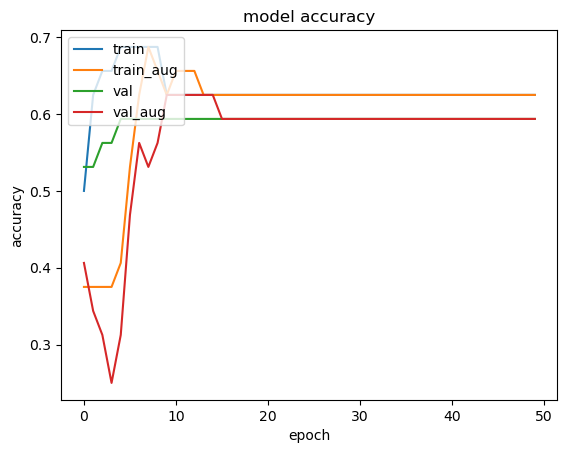

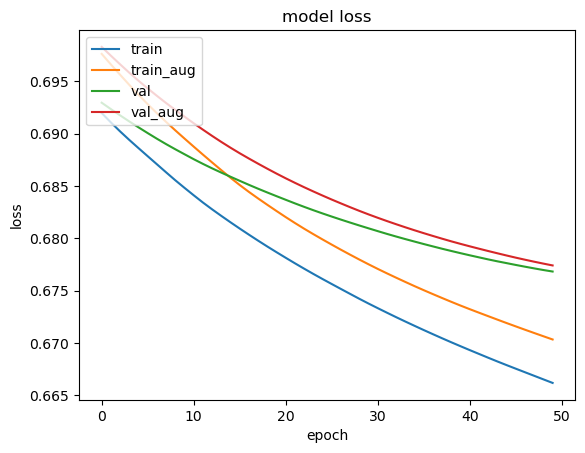

In [74]:
plt.plot(history.history['accuracy'])
plt.plot(history_aug.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.plot(history_aug.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train','train_aug', 'val','val_aug'], loc='upper left')
plt.show()

plt.plot(history.history['loss'])
plt.plot(history_aug.history['loss'])
plt.plot(history.history['val_loss'])
plt.plot(history_aug.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train','train_aug', 'val','val_aug'], loc='upper left')
plt.show()

With the chosen CNN the accuracy score is the same but the loss is lower on the augmented data, not by much though.

In [75]:
vggmodel = applications.VGG16(weights='imagenet', include_top=True)

image = load_img('./train/car/0005.jpg',target_size=(224,224))
image_array = img_to_array(image)
image_preprocessed = preprocess_input(image_array)
image_final = image_preprocessed.reshape(1,224,224,3)
prediction = vggmodel.predict(image_final)
decode_predictions(prediction)

1/1 [==============================] - 3s 3s/step


[[('n03345487', 'fire_engine', 0.29069436),
  ('n04461696', 'tow_truck', 0.22112119),
  ('n03478589', 'half_track', 0.10861439),
  ('n04037443', 'racer', 0.10831287),
  ('n04389033', 'tank', 0.052309193)]]

The image is a racecar and "racer" is included in the prediction. Furthermore the primary prediction is a vehicle of some sort it does a decent job but the chosen image could also affect the prediction, a racecar is more niche prediction compared to a normal car. Also the other predictions are for the most part vehicles that could often be seen in a racesetting.

## Part 3
Feature extraction

In [76]:
feature_extractor = applications.VGG16(include_top=False, weights='imagenet',
                                       input_shape=(img_size, img_size, 3))
vgg_data_gen = ImageDataGenerator(preprocessing_function=preprocess_input)
def create_vgg16_features(directory, file):
        vgg_train_generator = vgg_data_gen.flow_from_directory(
                directory,
                target_size=(img_size, img_size),
                batch_size=batch_size,
                class_mode='binary',
                classes=['other', 'car'],
                seed=12345,
                shuffle=False)
        cnn_features= feature_extractor.predict(vgg_train_generator)
        with open(file, 'wb') as f:
                np.save(f, cnn_features)

create_vgg16_features('./train/', './train.txt')
create_vgg16_features('./validation/', './validation.txt')





Found 1600 images belonging to 2 classes.
50/50 [==============================] - 47s 909ms/step
Found 576 images belonging to 2 classes.
18/18 [==============================] - 15s 806ms/step


Training model on extracted features and printing results

In [77]:
def get_labels(n):
    return np.array([0]*(n//2) + [1]*(n//2))


def train_on_cnnfeatures(): 
  with open('./train.txt', 'rb') as f:
    train_data = np.load(f)
  with open('./validation.txt', 'rb') as f:
    validation_data = np.load(f)
    print(validation_data[0])
  model = Sequential()
  model.add(Flatten())
  model.add(Dense(512, activation='relu'))
  model.add(Dense(1, activation='sigmoid'))
  model.compile(loss='binary_crossentropy',
              optimizer=(SGD(learning_rate=0.01,momentum=0.1, nesterov=True)),
              metrics=['accuracy'])
  labels_train = get_labels(1600)
  labels_val = get_labels(576)
  model.fit(train_data, labels_train,
            epochs=10,
            verbose=1,
            validation_data=(validation_data, labels_val))
  score = model.evaluate(validation_data, labels_val, verbose=0)
  print('Test loss:', score[0])
  print('Test accuracy:', score[1])
  return model

train_on_cnnfeatures()  



[[[15.603769  0.        0.       ...  0.        0.       21.160244]
  [21.658895  0.        0.       ...  0.        0.        0.      ]]

 [[ 0.        0.        0.       ...  0.        0.       24.641306]
  [ 0.        0.        0.       ...  0.        9.290994  8.250804]]]
Epoch 1/10
50/50 [==============================] - 2s 23ms/step - loss: 3.8612 - accuracy: 0.8487 - val_loss: 0.7296 - val_accuracy: 0.8594
Epoch 2/10
50/50 [==============================] - 1s 19ms/step - loss: 0.1743 - accuracy: 0.9663 - val_loss: 0.4633 - val_accuracy: 0.9115
Epoch 3/10
50/50 [==============================] - 2s 42ms/step - loss: 0.0260 - accuracy: 0.9950 - val_loss: 0.4672 - val_accuracy: 0.9080
Epoch 4/10
50/50 [==============================] - 2s 33ms/step - loss: 0.0048 - accuracy: 0.9994 - val_loss: 0.4469 - val_accuracy: 0.9115
Epoch 5/10
50/50 [==============================] - 2s 31ms/step - loss: 0.0026 - accuracy: 1.0000 - val_loss: 0.4656 - val_accuracy: 0.9115
Epoch 6/10
50/50 [=

Using the VGG16 model for extraction we can see a better performing model with less loss and better accuracy. This is achieved with the same settings for the density function, loss function and optimizer.

## Part 4: Visualizing the learned features

(3, 3, 3, 64)


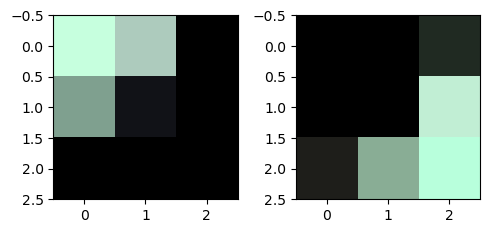

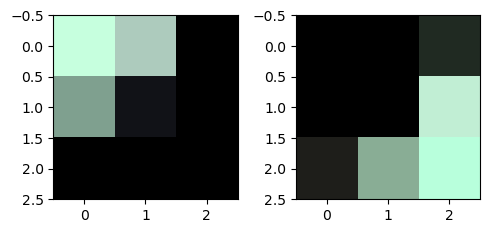

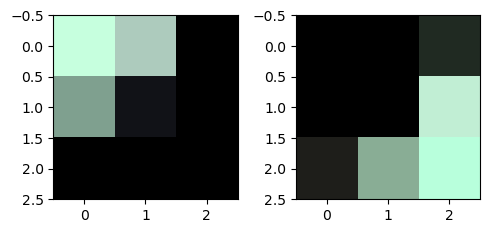

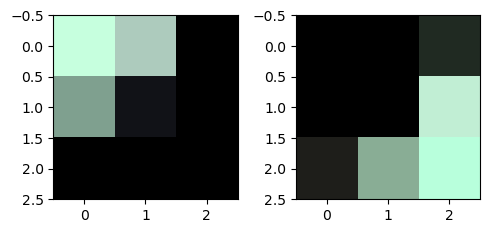

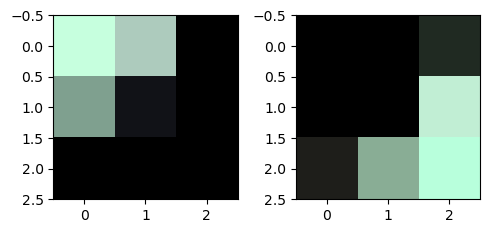

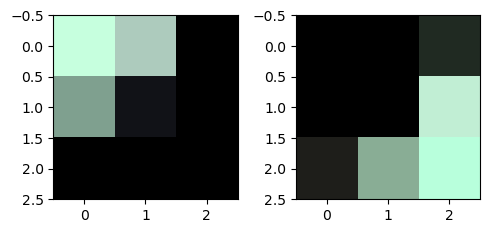

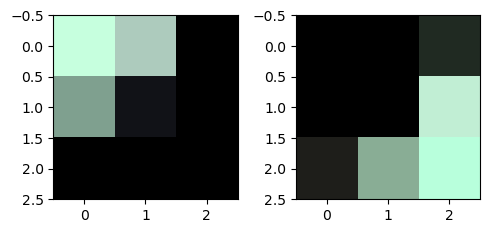

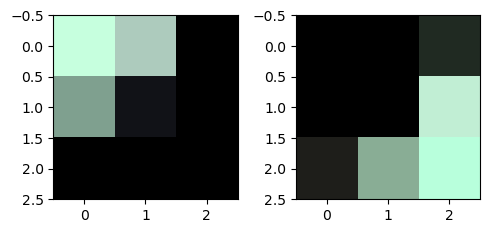

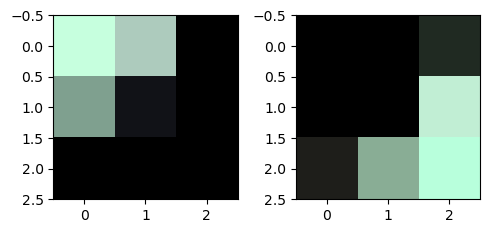

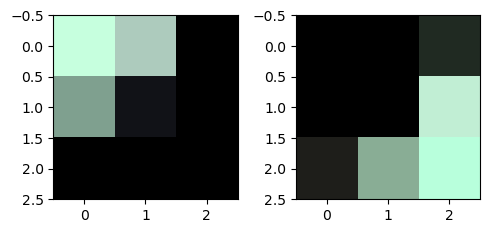

In [85]:
first_layer_weights = vggmodel.get_weights()[0]
print(first_layer_weights.shape)

# weights = first_layer_weights
# i = convolutional filter/kernel at position i (0-63)
# positive = positive or negative part of filter
def kernel_image(weights, i, positive):
    
    # extract the convolutional kernel at position i
    k = weights[:,:,:,i].copy()
    if not positive:
        k = -k
    
    # clip the values: if we're looking for positive
    # values, just keep the positive part; vice versa
    # for the negative values.
    k *= k > 0

    # rescale the colors, to make the images less dark
    m = k.max()
    if m > 1e-3:
        k /= m 

    return k

# visualize patterns in the first convolutional layer, positive and negative
for i in range(0,10):
    fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(5, 3))
    axes[0].imshow(kernel_image(first_layer_weights, i, positive=True),label=f"filter {i}(positive)")
    axes[1].imshow(kernel_image(first_layer_weights, i, positive=False),label=f"filter {i} (negative)")
    fig.tight_layout()